# Part 1

Import Libraries

In [2]:
import numpy as np
import modern_robotics as mr
import matplotlib.pyplot as plt
import random

# Set print options for numpy arrays
np.set_printoptions(precision=3, suppress=True)

Util Functions

In [11]:
def pi2pi(angle):
    while angle > np.pi:
        angle -= 2*np.pi
    while angle < -np.pi:
        angle += 2*np.pi
    return angle

def print_iteration(M, B, V_b, index, joint_vector):
    joint_vector = np.array(joint_vector)
    joint_vector = joint_vector.tolist()

    print(f"Iteration {index}:\n")

    print("joint vector:")
    joint_vector_to_print = joint_vector
    for i in range(len(joint_vector_to_print)):
        joint_vector_to_print[i] = round(joint_vector_to_print[i], 3)
    print(f"{str(joint_vector_to_print)[1:-1]}\n")

    print("SE(3) end-effector config:")
    Tsb = mr.FKinBody(M, B, joint_vector)
    decimal_places = 3
    width = 6
    print('\n'.join(' '.join(f"{cell:{width}.{decimal_places}f}" for cell in row) for row in Tsb))
    print()

    decimal_places = 3
    Vb_to_print = V_b.tolist()
    for i in range(len(Vb_to_print)):
        Vb_to_print[i] = round(Vb_to_print[i], decimal_places)
    Vb_to_print = tuple(Vb_to_print)
    print(f"          error twist V_b: {Vb_to_print}")
    print(f"angular error ||omega_b||: {np.linalg.norm([V_b[0], V_b[1], V_b[2]])}")
    print(f"     linear error ||v_b||: {np.linalg.norm([V_b[3], V_b[4], V_b[5]])}\n")
    print("=========================================================================")

def save_csv(filename, data):
    np.savetxt(filename, data, delimiter=',')

def Vb(M, B, T_sd, joint_vector):
    Vb = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, B, joint_vector)), T_sd)))
    return Vb

def check_convergence(V_b, eps_w, eps_v):
    return (np.linalg.norm([V_b[0], V_b[1], V_b[2]]) > eps_w \
         or np.linalg.norm([V_b[3], V_b[4], V_b[5]]) > eps_v)

def IKinBodyIterates(M, B, T_sd, theta_0, traj_filename, max_iterations=100, eps_w=1e-3, eps_v=1e-4, printing='true'):
    index = 1
    joint_vector = np.array(theta_0)
    joint_vector = joint_vector.tolist()
    V_b = Vb(M, B, T_sd, theta_0)

    # For saving later
    traj = np.array(joint_vector)
    angular_error = np.array(np.linalg.norm([V_b[0], V_b[1], V_b[2]]))
    linear_error = np.array(np.linalg.norm([V_b[3], V_b[4], V_b[5]]))

    iterating = check_convergence(V_b, eps_w, eps_v)
    
    while iterating and index < max_iterations:
        joint_vector = joint_vector + np.dot(np.linalg.pinv(mr.JacobianBody(B, joint_vector)), V_b)
        joint_vector = [np.arctan2(np.sin(theta), np.cos(theta)) for theta in joint_vector]
        V_b = Vb(M, B, T_sd, joint_vector)
        if(printing):
            print_iteration(M, B, V_b, index, joint_vector)
        traj = np.vstack([traj, joint_vector])
        angular_error = np.vstack([angular_error, np.array(np.linalg.norm([V_b[0], V_b[1], V_b[2]]))])
        linear_error = np.vstack([linear_error, np.array(np.linalg.norm([V_b[3], V_b[4], V_b[5]]))])
        iterating = check_convergence(V_b, eps_w, eps_v)

        if(iterating == False):
            if(printing):
                print(f"Converged. It took {index} iterations.")
                print("Trajectory:")
                print(traj)
                save_csv(traj_filename+'.csv', traj)
                save_csv(traj_filename+'_angular_error.csv', angular_error)
                save_csv(traj_filename+'_linear_error.csv', linear_error)
            break
        
        index += 1
    
    return index

def joint_traj2position_traj(joint_traj):
    joint_vector = joint_traj[0]
    pose_matrix = mr.FKinBody(M, B, joint_vector)
    position = pose_matrix[:3, 3]
    position_traj = np.array(position)
    for idx in range(1, joint_traj.shape[0]):
        joint_vector = joint_traj[idx]
        pose_matrix = mr.FKinBody(M, B, joint_vector)
        position = pose_matrix[:3, 3]
        position_traj = np.vstack([position_traj, position])
    return position_traj

def plot_position_traj(long_filename, short_filename):
    long_angle_traj = np.genfromtxt(long_filename+'.csv', delimiter=',')
    short_angle_traj = np.genfromtxt(short_filename+'.csv', delimiter=',')
    long_position_traj = joint_traj2position_traj(long_angle_traj)
    short_position_traj = joint_traj2position_traj(short_angle_traj)

    # Plot two trajectories in 3D space
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(long_position_traj[0,0], long_position_traj[0,1], long_position_traj[0,2], 'o', label='start of long traj')
    ax.plot(long_position_traj[:, 0], long_position_traj[:, 1], long_position_traj[:, 2], label='long_traj')
    ax.plot(long_position_traj[-1,0], long_position_traj[-1,1], long_position_traj[-1,2], 'x', label='end of long traj')

    ax.plot(short_position_traj[0,0], short_position_traj[0,1], short_position_traj[0,2], 'o', label='start of short traj')
    ax.plot(short_position_traj[:, 0], short_position_traj[:, 1], short_position_traj[:, 2], label='short_traj')
    ax.plot(short_position_traj[-1,0], short_position_traj[-1,1], short_position_traj[-1,2], 'x', label='end of short traj')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

def plot_angular_error(long_filename, short_filename):
    long_angular_error = np.genfromtxt(long_filename+'_angular_error.csv', delimiter=',')
    short_angular_error = np.genfromtxt(short_filename+'_angular_error.csv', delimiter=',')
    plt.plot(long_angular_error, label='long_traj')
    plt.plot(short_angular_error, label='short_traj')
    plt.xlabel('Iterations')
    plt.ylabel('Angular Error')
    plt.legend()
    plt.show()

def plot_linear_error(long_filename, short_filename):
    long_linear_error = np.genfromtxt(long_filename+'_linear_error.csv', delimiter=',')
    short_linear_error = np.genfromtxt(short_filename+'_linear_error.csv', delimiter=',')
    plt.plot(long_linear_error, label='long_traj')
    plt.plot(short_linear_error, label='short_traj')
    plt.xlabel('Iterations')
    plt.ylabel('Linear Error')
    plt.legend()
    plt.show()

def filter_initial_guess(M, B, T_sd, lb, ub):
    # give a random initial guess
    ites = 0
    while (ites>=ub or ites<=lb):
        random_initial_guess = [random.uniform(-np.pi, np.pi) for i in range(6)]
        # round to 3 decimal places
        random_initial_guess = [round(i, 3) for i in random_initial_guess]
        random_traj_name = "random_traj"
        ites = IKinBodyIterates(M, B, T_sd, random_initial_guess, random_traj_name, printing=False)
    print(f"Found initial guess: {random_initial_guess} with {ites} iterations to converge.")
    return random_initial_guess

Constants

In [4]:
L1 = 0.425
L2 = 0.392
H1 = 0.089
H2 = 0.095
W1 = 0.109
W2 = 0.082

# Home Configuration:
M = np.array([[-1, 0, 0, L1+L2],
              [0, 0, 1, W1+W2],
              [0, 1, 0, H1-H2],
              [0, 0, 0, 1]])

# B:
B_list = []
B_list.append(np.array([0, 1, 0, W1+W2, 0, L1+L2]))
B_list.append(np.array([0, 0, 1, H2, -L1-L2, 0]))
B_list.append(np.array([0, 0, 1, H2, -L2, 0]))
B_list.append(np.array([0, 0, 1, H2, 0, 0]))
B_list.append(np.array([0, -1, 0, -W2, 0, 0]))
B_list.append(np.array([0, 0, 1, 0, 0, 0]))
B = np.column_stack(B_list)

# T_sd:
T_sd = np.array([[1, 0, 0, 0.3],
                 [0, 1, 0, 0.3],
                 [0, 0, 1, 0.4],
                 [0, 0, 0, 1]])

Find Appropriate Initial Theta Lists

In [5]:
# converges after 2–4 Newton-Raphson steps (short iterates), not more or less
short_traj_initial_guess = filter_initial_guess(M, B, T_sd, 2, 4)

# converges after 10 Newton-Raphson steps, or never converges (long iterates).
long_traj_initial_guess = filter_initial_guess(M, B, T_sd, 11, np.inf)

Found initial guess: [-1.554, 2.462, 1.464, 0.288, 1.801, 0.389] with 3 iterations to converge.
Found initial guess: [0.834, -0.491, 3.134, -1.729, -0.532, 2.921] with 22 iterations to converge.


Solve IK With the Initial Guess Resulting in **Long** Trajectory

In [16]:
long_traj_name = "long iterates"
IKinBodyIterates(M, B, T_sd, long_traj_initial_guess, long_traj_name)

Iteration 1:

joint vector:
-2.47, -2.957, -3.093, 2.928, -0.025, 1.527

SE(3) end-effector config:
-0.020  0.798  0.602  0.144
-0.014  0.602 -0.798 -0.129
-1.000 -0.024 -0.000  0.171
 0.000  0.000  0.000  1.000

          error twist V_b: (-0.705, -1.459, 0.739, -0.178, 0.52, 0.09)
angular error ||omega_b||: 1.781107191540879
     linear error ||v_b||: 0.5573832230715222

Iteration 2:

joint vector:
0.863, 1.843, 2.831, 1.255, -2.59, -0.519

SE(3) end-effector config:
 0.909  0.259  0.328 -0.119
 0.362 -0.097 -0.927 -0.078
-0.209  0.961 -0.182 -0.033
 0.000  0.000  0.000  1.000

          error twist V_b: (-1.688, -0.479, -0.092, 0.357, 0.661, 0.104)
angular error ||omega_b||: 1.7572528705011987
     linear error ||v_b||: 0.757821864184124

Iteration 3:

joint vector:
-1.232, -0.326, 0.048, -0.741, 0.916, -1.345

SE(3) end-effector config:
 0.420  0.562  0.713  0.447
-0.656  0.730 -0.190 -0.791
-0.627 -0.388  0.675  0.338
 0.000  0.000  0.000  1.000

          error twist V_b: (0.125,

22

Solve IK With the Initial Guess Resulting in **Short** Trajectory

In [17]:
short_traj_name = "short iterates"
IKinBodyIterates(M, B, T_sd, short_traj_initial_guess, short_traj_name)

Iteration 1:

joint vector:
-1.991, 2.845, 1.655, 0.261, 1.686, 0.434

SE(3) end-effector config:
 0.992 -0.011 -0.125  0.250
 0.011  1.000  0.003  0.316
 0.125 -0.004  0.992  0.425
 0.000  0.000  0.000  1.000

          error twist V_b: (0.004, 0.125, -0.011, 0.048, -0.016, -0.028)
angular error ||omega_b||: 0.12534507476104986
     linear error ||v_b||: 0.057951035716249905

Iteration 2:

joint vector:
-2.102, 2.792, 1.651, 0.281, 1.566, 0.529

SE(3) end-effector config:
 1.000  0.002 -0.002  0.301
-0.002  1.000 -0.012  0.296
 0.002  0.012  1.000  0.402
 0.000  0.000  0.000  1.000

          error twist V_b: (-0.013, 0.002, 0.002, -0.001, 0.004, -0.002)
angular error ||omega_b||: 0.013039491663839251
     linear error ||v_b||: 0.004693607444187299

Iteration 3:

joint vector:
-2.096, 2.785, 1.651, 0.276, 1.571, 0.526

SE(3) end-effector config:
 1.000 -0.001  0.000  0.300
 0.001  1.000  0.000  0.300
-0.000 -0.000  1.000  0.400
 0.000  0.000  0.000  1.000

          error twist V_b: (

3

Plot the results

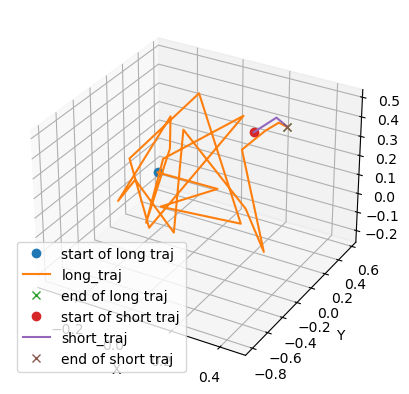

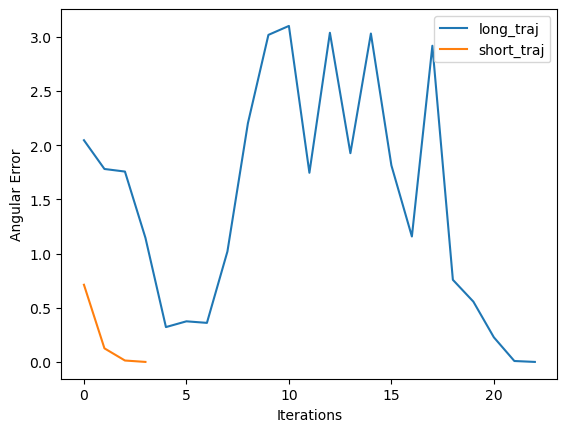

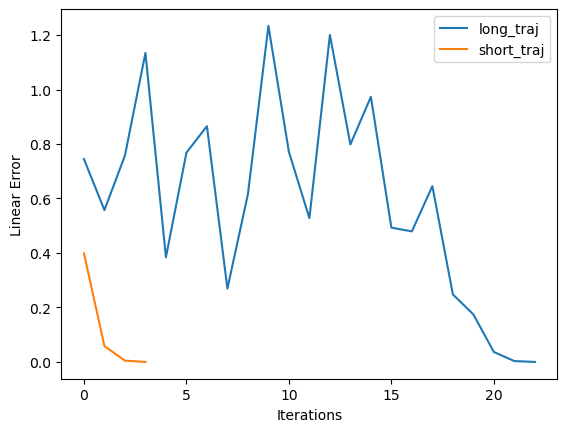

In [18]:
plot_position_traj(long_traj_name, short_traj_name)
plot_angular_error(long_traj_name, short_traj_name)
plot_linear_error(long_traj_name, short_traj_name)

## Explaination
When the initial guess is far from the actual solution, the algorithm might take long steps in the wrong direction, struggle to find the correct gradient, or even diverge. 

## Visualization
**Long** Trajectory IK in Simulation Visualization
* Initial Configuration
  ![long_start](long_start.png)
* End
  ![long_end](long_end.png)


**Short** Trajectory IK in Simulation Visualization
* Initial Configuration
  ![short_start](short_start.png)
* End
  ![short_end](short_end.png)

# Part 2

Imagine the robot is powered up at a random configuration $\theta^0$ such that $T_{sb}(\theta^0) = T^0$, and its first task is to move to a $\theta^*$ satisfying $T_{sb}(\theta^*) = T_{sd}$. Part 1 of this assignment deals with calculating an appropriate $\theta^*$. In this part, you will consider how to actually control the robot to move from rest at $\theta^0$ to rest at $\theta^*$ in $t_f$ seconds.

(a) If you decide to move at constant joint speeds, what joint speed vector $\dot{\theta}$ do you command to
the joints? Your answer should be symbolic in terms of relevant variables

**Answer**: 
$$
\Delta \theta = \theta^* - \theta^0 = \dot{\theta}\cdot t_f
$$
$$
Thus,\ \dot{\theta} = \frac{\theta^* - \theta^0}{t_f}
$$

(b) If you decide to make the last link of the robot follow a single constant twist from $T^0$ to $R_{sd}$, what joint speed vector $\dot{\theta}(0)$ do you command to the joints at time $t = 0$? What is the commanded joint speed vector $\dot{\theta}(t_f/2)$, halfway through the motion? Your answers should be symbolic in terms of relevant variables. Use the function ***vec(***$[\mathcal{V}]$***)*** to convert $[\mathcal{V}]\in se(3)$ to the twist $\mathcal{V}\in \R^6$, and assume you have access to the body Jacobian $J_b(\theta)$.


**Answer**: 
* Determine the Twist $\mathcal{V}$ to move from $T^0$ to $T_{sb}$
  $$ \mathcal{V} = \frac{vec(log((T^0)^{-1}T_{sd}))}{t_f} $$

* Determine $\dot{\theta}(0)$
  $$
  \mathcal{V} = J_b(\theta^0)\dot{\theta}(0)
  \\
  \dot{\theta}(0)=J_b(\theta^0)^{-1}\mathcal{V}
  $$
  $$
  Thus,\ \dot{\theta}(0) = \frac{J_b(\theta^0)^{-1}  vec(log((T^0)^{-1}T_{sd}))}{t_f}
  $$

* Determine $\dot{\theta}(t_f/2)$
  $$
  \dot{\theta}({t_f/2})=J_b(\theta^{t_f/2})^{-1}\mathcal{V}
  $$
  $$
  Thus,\ \dot{\theta}({t_f/2}) = \frac{J_b(\theta^{t_f/2})^{-1}  vec(log((T^0)^{-1}T_{sd}))}{t_f}
  $$


(c) Do you see any advantages to using the approach in (a) relative to (b), or vice-versa?

**Answer**:
* (a) is more simple in control strategy and has lower computational cost.
* (a) lacks direct cartesian path control for end effector, which can be dangerous in real world. (b) directly uses the information in cartesian space. 